##  IMPORT DEPENDENCIES

In [84]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# nltk
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## READ & LOAD  DATASET

In [85]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('twittter.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1523299,4,2176563157,Mon Jun 15 04:12:05 PDT 2009,NO_QUERY,steviekaye,all time low's new song= very groovy haha
79291,0,1751774325,Sat May 09 20:14:39 PDT 2009,NO_QUERY,tdbriz,Royals lose 1-0. That's Zack's 1st loss this y...
958208,4,1825661014,Sun May 17 06:27:14 PDT 2009,NO_QUERY,makefate,@lareine27 i am! im pmsing too. must be in the...
1265114,4,1999377971,Mon Jun 01 20:06:50 PDT 2009,NO_QUERY,Brandon_Hill,@zac_efron Smooth way to be introduced at the ...
339398,0,2014635538,Wed Jun 03 02:10:58 PDT 2009,NO_QUERY,char_s1,Is Feeling Tiredd And Not Very Well !!!


## DATA ANALYSIS

In [86]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [87]:
print('length of data is', len(df))

length of data is 1600000


In [88]:
df. shape

(1600000, 6)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [90]:
# CHECK FOR NULL VALUES
np.sum(df.isnull().any(axis=1))

0

## VISUALITION OF DATA

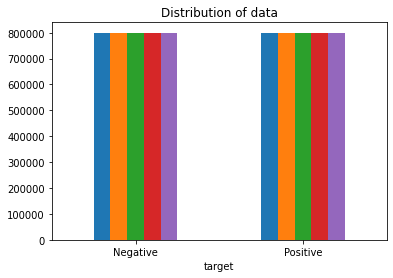

In [91]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists
text, sentiment = list(df['text']), list(df['target'])

<AxesSubplot:xlabel='target', ylabel='count'>

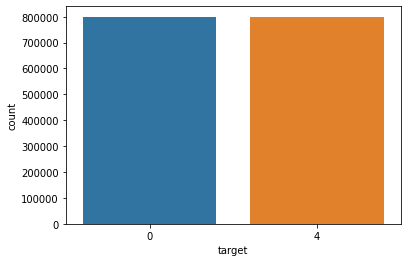

In [92]:
import seaborn as sns
sns.countplot(x='target', data=df)


In [93]:
dataset=df[['target','text']]
dataset['target'] = dataset['target'].replace(4,1)
dataset['target'].unique()

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/66088381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['target'] = dataset['target'].replace(4,1)


array([0, 1], dtype=int64)

# Data Preprocessing


In [94]:
#removing html entities
from html.entities import html5 as _html5

_invalid_charrefs = {
    0x00: '\ufffd',  # REPLACEMENT CHARACTER
    0x0d: '\r',      # CARRIAGE RETURN
    0x80: '\u20ac',  # EURO SIGN
    0x81: '\x81',    # <control>
    0x82: '\u201a',  # SINGLE LOW-9 QUOTATION MARK
    0x83: '\u0192',  # LATIN SMALL LETTER F WITH HOOK
    0x84: '\u201e',  # DOUBLE LOW-9 QUOTATION MARK
    0x85: '\u2026',  # HORIZONTAL ELLIPSIS
    0x86: '\u2020',  # DAGGER
    0x87: '\u2021',  # DOUBLE DAGGER
    0x88: '\u02c6',  # MODIFIER LETTER CIRCUMFLEX ACCENT
    0x89: '\u2030',  # PER MILLE SIGN
    0x8a: '\u0160',  # LATIN CAPITAL LETTER S WITH CARON
    0x8b: '\u2039',  # SINGLE LEFT-POINTING ANGLE QUOTATION MARK
    0x8c: '\u0152',  # LATIN CAPITAL LIGATURE OE
    0x8d: '\x8d',    # <control>
    0x8e: '\u017d',  # LATIN CAPITAL LETTER Z WITH CARON
    0x8f: '\x8f',    # <control>
    0x90: '\x90',    # <control>
    0x91: '\u2018',  # LEFT SINGLE QUOTATION MARK
    0x92: '\u2019',  # RIGHT SINGLE QUOTATION MARK
    0x93: '\u201c',  # LEFT DOUBLE QUOTATION MARK
    0x94: '\u201d',  # RIGHT DOUBLE QUOTATION MARK
    0x95: '\u2022',  # BULLET
    0x96: '\u2013',  # EN DASH
    0x97: '\u2014',  # EM DASH
    0x98: '\u02dc',  # SMALL TILDE
    0x99: '\u2122',  # TRADE MARK SIGN
    0x9a: '\u0161',  # LATIN SMALL LETTER S WITH CARON
    0x9b: '\u203a',  # SINGLE RIGHT-POINTING ANGLE QUOTATION MARK
    0x9c: '\u0153',  # LATIN SMALL LIGATURE OE
    0x9d: '\x9d',    # <control>
    0x9e: '\u017e',  # LATIN SMALL LETTER Z WITH CARON
    0x9f: '\u0178',  # LATIN CAPITAL LETTER Y WITH DIAERESIS
}

_invalid_codepoints = {
    # 0x0001 to 0x0008
    0x1, 0x2, 0x3, 0x4, 0x5, 0x6, 0x7, 0x8,
    # 0x000E to 0x001F
    0xe, 0xf, 0x10, 0x11, 0x12, 0x13, 0x14, 0x15, 0x16, 0x17, 0x18, 0x19,
    0x1a, 0x1b, 0x1c, 0x1d, 0x1e, 0x1f,
    # 0x007F to 0x009F
    0x7f, 0x80, 0x81, 0x82, 0x83, 0x84, 0x85, 0x86, 0x87, 0x88, 0x89, 0x8a,
    0x8b, 0x8c, 0x8d, 0x8e, 0x8f, 0x90, 0x91, 0x92, 0x93, 0x94, 0x95, 0x96,
    0x97, 0x98, 0x99, 0x9a, 0x9b, 0x9c, 0x9d, 0x9e, 0x9f,
    # 0xFDD0 to 0xFDEF
    0xfdd0, 0xfdd1, 0xfdd2, 0xfdd3, 0xfdd4, 0xfdd5, 0xfdd6, 0xfdd7, 0xfdd8,
    0xfdd9, 0xfdda, 0xfddb, 0xfddc, 0xfddd, 0xfdde, 0xfddf, 0xfde0, 0xfde1,
    0xfde2, 0xfde3, 0xfde4, 0xfde5, 0xfde6, 0xfde7, 0xfde8, 0xfde9, 0xfdea,
    0xfdeb, 0xfdec, 0xfded, 0xfdee, 0xfdef,
    # others
    0xb, 0xfffe, 0xffff, 0x1fffe, 0x1ffff, 0x2fffe, 0x2ffff, 0x3fffe, 0x3ffff,
    0x4fffe, 0x4ffff, 0x5fffe, 0x5ffff, 0x6fffe, 0x6ffff, 0x7fffe, 0x7ffff,
    0x8fffe, 0x8ffff, 0x9fffe, 0x9ffff, 0xafffe, 0xaffff, 0xbfffe, 0xbffff,
    0xcfffe, 0xcffff, 0xdfffe, 0xdffff, 0xefffe, 0xeffff, 0xffffe, 0xfffff,
    0x10fffe, 0x10ffff
}


def _replace_charref(s):
    s = s.group(1)
    if s[0] == '#':
        # numeric charref
        if s[1] in 'xX':
            num = int(s[2:].rstrip(';'), 16)
        else:
            num = int(s[1:].rstrip(';'))
        if num in _invalid_charrefs:
            return _invalid_charrefs[num]
        if 0xD800 <= num <= 0xDFFF or num > 0x10FFFF:
            return '\uFFFD'
        if num in _invalid_codepoints:
            return ''
        return chr(num)
    else:
        # named charref
        if s in _html5:
            return _html5[s]
        # find the longest matching name (as defined by the standard)
        for x in range(len(s)-1, 1, -1):
            if s[:x] in _html5:
                return _html5[s[:x]] + s[x:]
        else:
            return '&' + s


_charref = re.compile(r'&(#[0-9]+;?'
                       r'|#[xX][0-9a-fA-F]+;?'
                       r'|[^\t\n\f <&#;]{1,32};?)')

def unescape(s):
    """
    Convert all named and numeric character references (e.g. &gt;, &#62;,
    &x3e;) in the string s to the corresponding unicode characters.
    This function uses the rules defined by the HTML 5 standard
    for both valid and invalid character references, and the list of
    HTML 5 named character references defined in html.entities.html5.
    """
    if '&' not in s:
        return s
    return _charref.sub(_replace_charref, s)


In [95]:
dataset['clean_tweet'] = dataset['text'].apply(lambda x: unescape(x))
dataset.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/3734098641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = dataset['text'].apply(lambda x: unescape(x))


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew,@Kwesidei not the whole crew
6,0,Need a hug,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?,@twittera que me muera ?


In [96]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [97]:
#removing @user from all tweets
dataset['clean_tweet'] = np.vectorize(remove_pattern)(dataset['clean_tweet'], "@[\w]*")
dataset.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/4019182742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = np.vectorize(remove_pattern)(dataset['clean_tweet'], "@[\w]*")


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","http://twitpic.com/2y1zl - Awww, that's a bum..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,"hey long time no see! Yes.. Rains a bit ,onl..."
8,0,@Tatiana_K nope they didn't have it,nope they didn't have it
9,0,@twittera que me muera ?,que me muera ?


In [98]:
#converting all tweets to lowercase
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: x.lower())
dataset.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/2145782131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: x.lower())


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","http://twitpic.com/2y1zl - awww, that's a bum..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am..."
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,"hey long time no see! yes.. rains a bit ,onl..."
8,0,@Tatiana_K nope they didn't have it,nope they didn't have it
9,0,@twittera que me muera ?,que me muera ?


In [99]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [100]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [101]:
#fixing aphostrophe words
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: lookup_dict(x,apostrophe_dict))
dataset.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/2528880971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: lookup_dict(x,apostrophe_dict))


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","http://twitpic.com/2y1zl - awww, that has / t..."
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it has / it is not behaving at all. I am ..."
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,"hey long time no see! yes.. rains a bit ,onl..."
8,0,@Tatiana_K nope they didn't have it,nope they did not have it
9,0,@twittera que me muera ?,que me muera ?


In [102]:
#converting short form to full form
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: lookup_dict(x,apostrophe_dict))
dataset.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/3319259832.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: lookup_dict(x,apostrophe_dict))


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","http://twitpic.com/2y1zl - awww, that has / t..."
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it has / it is not behaving at all. I am ..."
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,"hey long time no see! yes.. rains a bit ,onl..."
8,0,@Tatiana_K nope they didn't have it,nope they did not have it
9,0,@twittera que me muera ?,que me muera ?


In [103]:
#fixing emoticons in tweets
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))
dataset.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/2744581078.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","http://twitpic.com/2y1zl - awww, that has / t..."
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball. managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it has / it is not behaving at all. I am ..."
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,"hey long time no see! yes.. rains a bit ,onl..."
8,0,@Tatiana_K nope they didn't have it,nope they did not have it
9,0,@twittera que me muera ?,que me muera ?


In [104]:
#removing punctuations with space
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))
dataset.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/307333683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",http twitpic com 2y1zl awww that has t...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it has it is not behaving at all I am ...
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time no see yes rains a bit onl...
8,0,@Tatiana_K nope they didn't have it,nope they did not have it
9,0,@twittera que me muera ?,que me muera


In [105]:
#removing special chars
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
dataset.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/3697365121.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",http twitpic com 2y1zl awww that has t...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it has it is not behaving at all I am ...
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time no see yes rains a bit onl...
8,0,@Tatiana_K nope they didn't have it,nope they did not have it
9,0,@twittera que me muera ?,que me muera


In [106]:
#removing numbers from tweet
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))
dataset.head(5)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/1923919843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",http twitpic com y zl awww that has t...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to s...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it has it is not behaving at all I am ...


In [107]:
#removing words of length 1
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
dataset.head(10)

C:\Users\Dell\AppData\Local\Temp/ipykernel_9876/4107121282.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))


,target,text,clean_tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",http twitpic com zl awww that has that is bumm...
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times for the ball managed to save ...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no it has it is not behaving at all am mad why...
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,need hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time no see yes rains bit only bit lo...
8,0,@Tatiana_K nope they didn't have it,nope they did not have it
9,0,@twittera que me muera ?,que me muera


In [108]:
data_pos=dataset[800000:1000000]
data_neg=dataset[:200000]

In [109]:
data=pd.concat([data_neg,data_pos])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   target       400000 non-null  int64 
 1   text         400000 non-null  object
 2   clean_tweet  400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 12.2+ MB


In [110]:

# Creating token for the clean tweets
data['tweet_token'] = data['clean_tweet'].apply(lambda x: word_tokenize(x))

## Fully formated tweets & there tokens
data.head(5)

,target,text,clean_tweet,tweet_token
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",http twitpic com zl awww that has that is bumm...,"[http, twitpic, com, zl, awww, that, has, that..."
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f..."
2,0,@Kenichan I dived many times for the ball. Man...,dived many times for the ball managed to save ...,"[dived, many, times, for, the, ball, managed, ..."
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,"@nationwideclass no, it's not behaving at all....",no it has it is not behaving at all am mad why...,"[no, it, has, it, is, not, behaving, at, all, ..."


In [111]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [112]:
stop_words = set(stopwords.words('english'))
## Tokens columns with stop words and without stop words
data['tweet_token_filtered'] = data['tweet_token'].apply(lambda x: [word for word in x if not word in stop_words])
data.head(5)

,target,text,clean_tweet,tweet_token,tweet_token_filtered
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",http twitpic com zl awww that has that is bumm...,"[http, twitpic, com, zl, awww, that, has, that...","[http, twitpic, com, zl, awww, bummer, shoulda..."
1,0,is upset that he can't update his Facebook by ...,is upset that he cannot update his facebook by...,"[is, upset, that, he, can, not, update, his, f...","[upset, update, facebook, texting, might, cry,..."
2,0,@Kenichan I dived many times for the ball. Man...,dived many times for the ball managed to save ...,"[dived, many, times, for, the, ball, managed, ...","[dived, many, times, ball, managed, save, rest..."
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",no it has it is not behaving at all am mad why...,"[no, it, has, it, is, not, behaving, at, all, ...","[behaving, mad, see]"


In [113]:
# Importing library for lemmatizing

lemmatizing = WordNetLemmatizer()
# Created one more columns tweet_lemmatized it shows tweets' lemmatized version
data['tweet_lemmatized'] = data['tweet_token_filtered'].apply(lambda x: ' '.join([lemmatizing.lemmatize(i) for i in x]))
data['tweet_lemmatized'].head(10)

0    http twitpic com zl awww bummer shoulda got da...
1    upset update facebook texting might cry result...
2      dived many time ball managed save rest go bound
3                      whole body feel itchy like fire
4                                     behaving mad see
5                                           whole crew
6                                             need hug
7    hey long time see yes rain bit bit lol fine th...
8                                                 nope
9                                            que muera
Name: tweet_lemmatized, dtype: object

# Extracting Feature from dataset

In [114]:
# Importing library
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=500000, stop_words='english')
bow_vectorizer

CountVectorizer(max_df=0.9, max_features=500000, min_df=2, stop_words='english')

In [115]:
# feature extraction for lemmatized tweets
bow_lem=bow_vectorizer.fit_transform(data['tweet_lemmatized'])
bow_lem

<400000x43741 sparse matrix of type '<class 'numpy.int64'>'
	with 2373424 stored elements in Compressed Sparse Row format>

# Splitting our data into Train and Test Subset

In [116]:
X_train, X_test, y_train, y_test = train_test_split(bow_lem, data['target'], random_state=26105111, test_size=0.05)

# Training and Testing 

## Function For Model Evaluation
After training the model we then apply the evaluation measures to check how the model is performing. Accordingly, we use the following evaluation parameters to check the performance of the models respectively :

Accuracy Score
Confusion Matrix with Plot
ROC-AUC Curve


In [117]:
def model_Evaluate(model):
# Predict values for Test dataset
 y_pred = model.predict(X_test)
 # Print the evaluation metrics for the dataset.
 print(classification_report(y_test, y_pred))
 # Compute and plot the Confusion matrix
 cf_matrix = confusion_matrix(y_test, y_pred)
 categories = ['Negative','Positive']
 group_names = ['True Neg','False Pos', 'False Neg','True Pos']
 group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
 labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
 labels = np.asarray(labels).reshape(2,2)
 sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
 xticklabels = categories, yticklabels = categories)
 plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
 plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
 plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
 plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Model Building
the problem statement we have used three different models respectively :

Bernoulli Naive Bayes
SVM (Support Vector Machine)
Logistic Regression
The idea behind choosing these models is that we want to try all the classifiers on the dataset ranging from simple ones to complex models and then try to find out the one which gives the best performance among them.

              precision    recall  f1-score   support

           0       0.76      0.75      0.75      9930
           1       0.76      0.76      0.76     10070

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



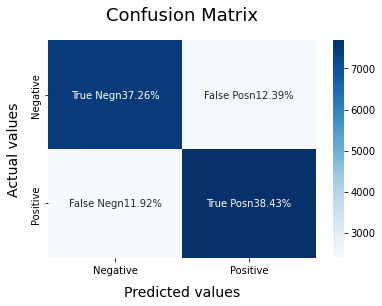

In [118]:
# Model-1

BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

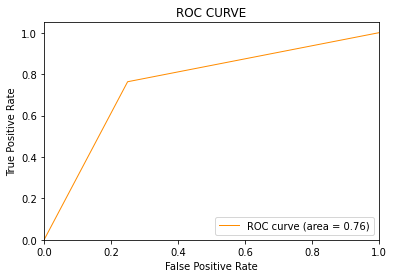

In [119]:
# Plot the ROC-AUC Curve for model-1

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

c:\Users\Dell\OneDrive\Desktop\TWITTER_SENTIMENT_ANALYSIS\venv\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.77      0.73      0.75      9930
           1       0.75      0.78      0.76     10070

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



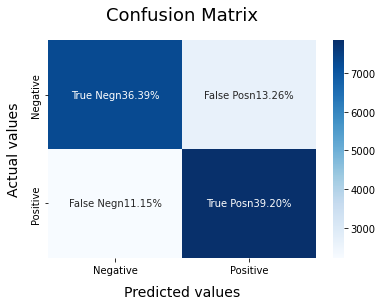

In [120]:
#Model-2:

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

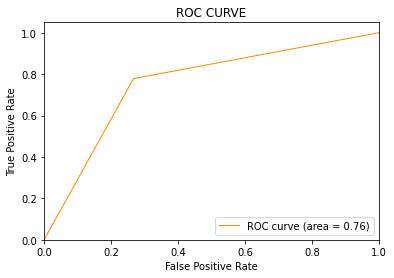

In [121]:
# the ROC-AUC Curve for model-2

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.77      0.74      0.76      9930
           1       0.75      0.78      0.77     10070

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000



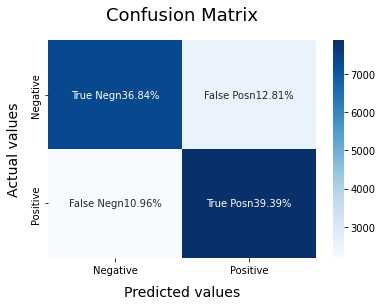

In [122]:
# Model-3

LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

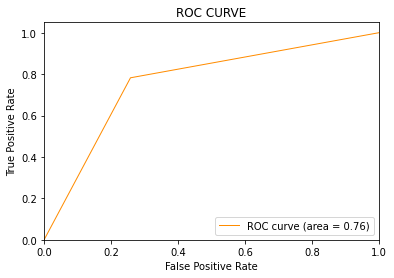

In [123]:
# the ROC-AUC Curve for model-3

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()